**Download dataset từ Kaggle**

In [ ]:
!pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nghiacsk13","key":"5e81dbf3abbc703ff070f53413d68f27"}'}

In [ ]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d msambare/fer2013

 81% 49.0M/60.3M [00:00<00:00, 57.6MB/s]
100% 60.3M/60.3M [00:00<00:00, 102MB/s] 


In [ ]:
!unzip fer2013.zip

**Import các thư viện cần thiết**

In [ ]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

**Chuẩn bị bộ train, test**

In [ ]:
# Hàm plot ảnh demo đơn giản
def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
  
    plt.figure(figsize=(10, 10))
  
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
    
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray') 

In [ ]:
train_dir = '/content/train'
val_dir = '/content/test'

# Ảnh có thang độ xám sẽ có mức xám từ 0-255, tỉ lệ này quá cao để model học, nên cần scale lại theo mức  từ 0-1
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Chuyển label của ảnh sang dạng one-hot encoding, ví dụ 
# happy => 0 0 0 1 0 0 0
# disgust => 0 1 0 0 0 0 0 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


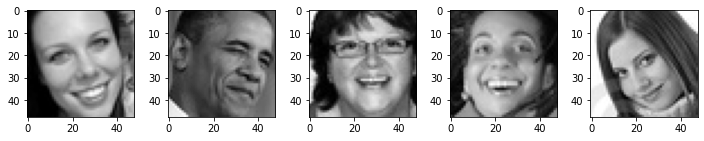

In [ ]:
#Plot thử ảnh happy
plot_images(train_dir+'/happy')

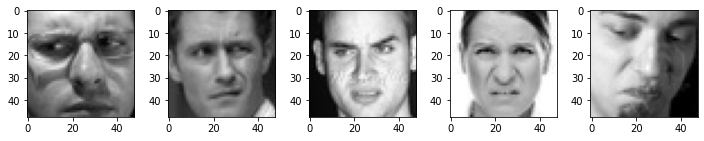

In [ ]:
#Plot thử ảnh disgust
plot_images(train_dir+'/disgust')

**Xây dựng CNN**

In [ ]:
# Nói cho keras biết là ta sẽ xếp các layer lên nhau để tạo model
emotion_model = Sequential()

# Thêm conv layer với 32 kernel, size 3*3, hàm kích hoạt là relu, layer đầu
# nên ta chỉ rõ input_shape là ảnh 48*48*1 (thang xám nên chỉ 1 kênh màu)
emotion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))

# Thêm một conv layer
emotion_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))

# Sử dụng max pooling để giảm bớt tham số trong quá trình train
# nhưng vẫn giữ nguyên đặt trưng
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))

# Sử dụng dropout để tránh overfit
emotion_model.add(Dropout(0.25))

# Tương tự như trên, nhưng số kernel lớn hơn
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
emotion_model.add(MaxPooling2D(pool_size=(2, 2)))
emotion_model.add(Dropout(0.25))

# Sau khi học được các đặc điểm của dataset
# ta sử dụng flatten để chuyển tensor thành vector
emotion_model.add(Flatten())

# Thêm FCL 1024 node, hàm kích hoạt là relu
emotion_model.add(Dense(1024, activation='relu'))
emotion_model.add(Dropout(0.5))

# Output layer là 7 node và dùng hàm softmax để chuyển sang xác suất
emotion_model.add(Dense(7, activation='softmax'))

![image.png](https://i0.wp.com/nttuan8.com/wp-content/uploads/2019/03/cnn.png?w=1024&ssl=1)

**Train model và đánh giá**

In [ ]:
# Train model với hàm loss là 'categorical_crossentropy' (classify nhiều classes), thang đánh giá là accuracy
emotion_model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])
emotion_model_info = emotion_model.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

**Save model vào file *.h5 để dùng cho ứng dụng demo**

In [ ]:
emotion_model.save_weights('model.h5')
